📂 Starting stroke classification preprocessing...



Loading Haemorrhagic: 100%|██████████| 186/186 [00:00<00:00, 223.40it/s]


✨ Enhancing images with OpenCV filters...


100%|██████████| 186/186 [00:00<00:00, 2975.30it/s]


🔍 Extracting features...


100%|██████████| 186/186 [03:46<00:00,  1.22s/it]


✅ Completed Haemorrhagic: 186 images processed.



Loading Ischemic: 100%|██████████| 30/30 [00:00<00:00, 301.36it/s]


✨ Enhancing images with OpenCV filters...


100%|██████████| 30/30 [00:00<00:00, 2726.47it/s]


🔍 Extracting features...


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


✅ Completed Ischemic: 30 images processed.



Loading Normal: 100%|██████████| 144/144 [00:00<00:00, 235.08it/s]


✨ Enhancing images with OpenCV filters...


100%|██████████| 144/144 [00:00<00:00, 3464.92it/s]


🔍 Extracting features...


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


✅ Completed Normal: 144 images processed.


📊 STROKE DATASET PREPROCESSING SUMMARY

🧠 Class: Haemorrhagic
   mean_intensity: 0.251 ± 0.030
   std_intensity: 0.333 ± 0.023
   contrast: 1.000 ± 0.000
   entropy: 5.574 ± 0.379
   homogeneity: 0.863 ± 0.018
   symmetry: 0.910 ± 0.019
   brain_area_ratio: 0.311 ± 0.057


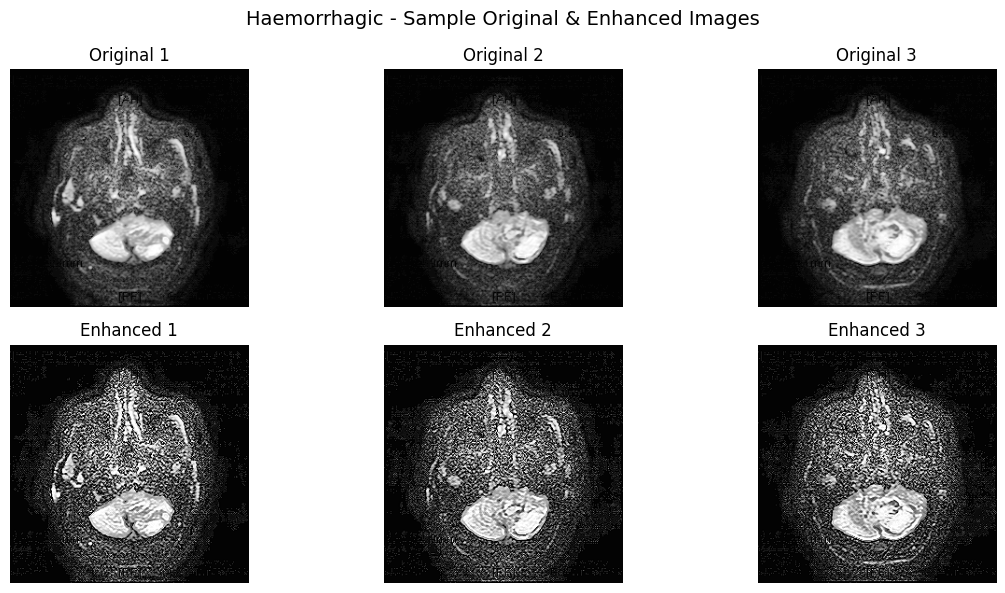


🧠 Class: Ischemic
   mean_intensity: 0.223 ± 0.034
   std_intensity: 0.300 ± 0.017
   contrast: 1.000 ± 0.000
   entropy: 5.588 ± 0.475
   homogeneity: 0.875 ± 0.024
   symmetry: 0.928 ± 0.023
   brain_area_ratio: 0.245 ± 0.053


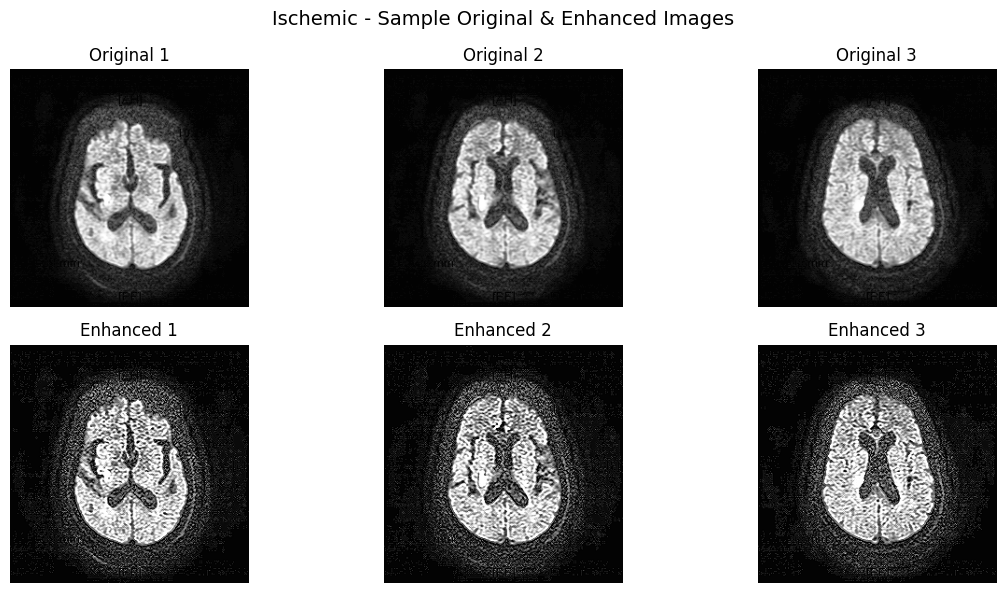


🧠 Class: Normal
   mean_intensity: 0.268 ± 0.028
   std_intensity: 0.337 ± 0.021
   contrast: 1.000 ± 0.000
   entropy: 5.812 ± 0.295
   homogeneity: 0.859 ± 0.015
   symmetry: 0.907 ± 0.017
   brain_area_ratio: 0.316 ± 0.062


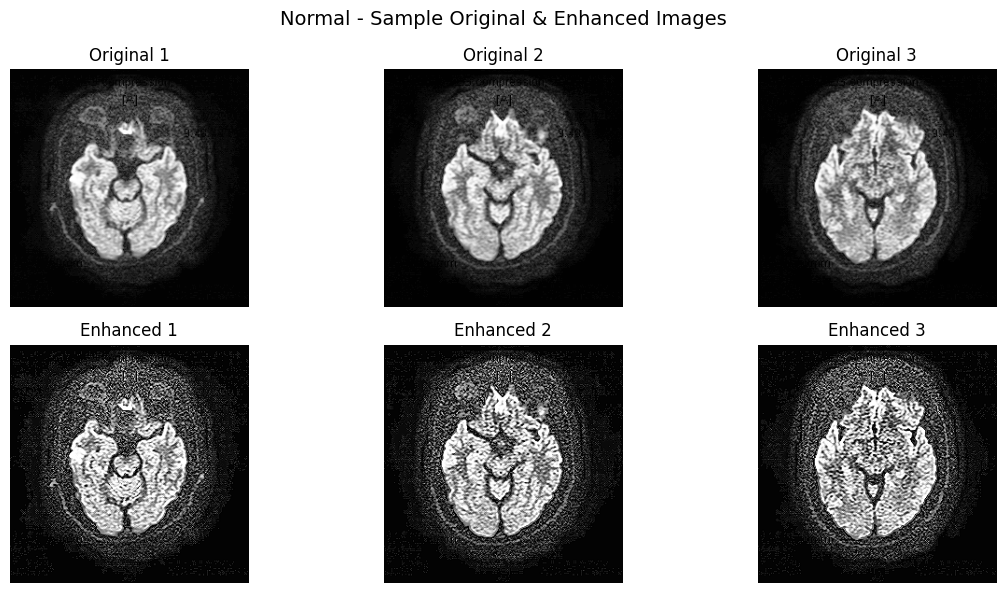

In [3]:
import numpy as np
import cv2
from scipy.ndimage import uniform_filter, generic_filter
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


# ------------------------------
# IMAGE ENHANCEMENT
# ------------------------------
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply((image * 255).astype(np.uint8))
    return enhanced.astype(np.float32) / 255.0


def enhance_with_cv_filters(slices):
    print("✨ Enhancing images with OpenCV filters...")
    enhanced_slices = []
    for img in tqdm(slices):
        img_8bit = (img * 255).astype(np.uint8)
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])  # sharpening kernel
        sharpened = cv2.filter2D(img_8bit, -1, kernel)
        enhanced = cv2.addWeighted(sharpened, 1.2, img_8bit, -0.2, 0)
        enhanced = np.clip(enhanced.astype(np.float32) / 255.0, 0, 1)
        enhanced_slices.append(enhanced)
    return enhanced_slices


# ------------------------------
# IMAGE QUALITY METRICS
# ------------------------------
def calculate_entropy(image):
    hist = np.histogram(image, bins=256, range=(0, 1))[0]
    hist = hist / (hist.sum() + 1e-10)
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    return entropy


def calculate_homogeneity(image):
    try:
        std_dev = generic_filter(image, np.std, size=5)
        homogeneity = 1 / (1 + np.mean(std_dev))
        return homogeneity
    except:
        return 0.5


def calculate_symmetry(image):
    h, w = image.shape
    left = image[:, :w // 2]
    right = np.fliplr(image[:, w // 2:])
    if left.shape == right.shape:
        mse = np.mean((left - right) ** 2)
        return 1 / (1 + mse)
    return 0.5


def estimate_brain_area(image):
    try:
        img_8bit = (image * 255).astype(np.uint8)
        _, thresh = cv2.threshold(img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest)
            return area / (image.shape[0] * image.shape[1])
    except:
        return 0
    return 0


# ------------------------------
# LOAD AND PROCESS IMAGES
# ------------------------------
def load_and_process_images(folder_path, target_size=(256, 256), enhance=True):
    processed = []
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]

    if len(image_files) == 0:
        print(f"⚠️ No images in {folder_path}")
        return processed

    for f in tqdm(image_files, desc=f"Loading {os.path.basename(folder_path)}"):
        img_path = os.path.join(folder_path, f)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                img = np.array(Image.open(img_path).convert('L'))
            img = cv2.resize(img, target_size)
            img = img.astype(np.float32) / 255.0
            if enhance:
                img = enhance_contrast(img)
            processed.append(img)
        except Exception as e:
            print(f"⚠️ Error loading {f}: {e}")
    return processed


# ------------------------------
# FEATURE EXTRACTION
# ------------------------------
def extract_image_features(images):
    print("🔍 Extracting features...")
    feats = []
    for i, img in enumerate(tqdm(images)):
        feats.append({
            'image_number': i + 1,
            'mean_intensity': np.mean(img),
            'std_intensity': np.std(img),
            'contrast': np.max(img) - np.min(img),
            'entropy': calculate_entropy(img),
            'homogeneity': calculate_homogeneity(img),
            'symmetry': calculate_symmetry(img),
            'brain_area_ratio': estimate_brain_area(img)
        })
    return feats


def get_feature_statistics(features):
    if not features:
        return {}
    names = ['mean_intensity', 'std_intensity', 'contrast', 'entropy',
             'homogeneity', 'symmetry', 'brain_area_ratio']
    stats = {}
    for n in names:
        vals = [f[n] for f in features]
        stats[n] = {'mean': np.mean(vals), 'std': np.std(vals),
                    'min': np.min(vals), 'max': np.max(vals)}
    return stats


# ------------------------------
# MAIN PROCESSING PIPELINE
# ------------------------------
def process_stroke_dataset(base_path):
    classes = ['Haemorrhagic', 'Ischemic', 'Normal']
    results = {}

    for cls in classes:
        folder = os.path.join(base_path, cls)
        if not os.path.exists(folder):
            print(f"⚠️ Missing folder: {folder}")
            continue

        images = load_and_process_images(folder)
        enhanced_images = enhance_with_cv_filters(images)
        features = extract_image_features(enhanced_images)
        stats = get_feature_statistics(features)

        results[cls] = {
            'images': images,
            'enhanced_images': enhanced_images,
            'features': features,
            'stats': stats
        }

        print(f"✅ Completed {cls}: {len(images)} images processed.\n")

    return results


def display_summary(results):
    print("\n" + "=" * 60)
    print("📊 STROKE DATASET PREPROCESSING SUMMARY")
    print("=" * 60)
    for cls, data in results.items():
        print(f"\n🧠 Class: {cls}")
        stats = data['stats']
        for k, v in stats.items():
            print(f"   {k}: {v['mean']:.3f} ± {v['std']:.3f}")

        # Display a few sample images
        imgs = data['images']
        enh = data['enhanced_images']
        if len(imgs) > 0:
            fig, axes = plt.subplots(2, min(3, len(imgs)), figsize=(12, 6))
            fig.suptitle(f"{cls} - Sample Original & Enhanced Images", fontsize=14)
            for i in range(min(3, len(imgs))):
                axes[0, i].imshow(imgs[i], cmap='gray')
                axes[0, i].set_title(f"Original {i+1}")
                axes[0, i].axis('off')

                axes[1, i].imshow(enh[i], cmap='gray')
                axes[1, i].set_title(f"Enhanced {i+1}")
                axes[1, i].axis('off')
            plt.tight_layout()
            plt.show()


# ------------------------------
# RUN SCRIPT
# ------------------------------
if __name__ == "__main__":
    base_folder = r"Stroke_classification"  # 👈 your dataset folder
    print("📂 Starting stroke classification preprocessing...\n")

    results = process_stroke_dataset(base_folder)

    if results:
        display_summary(results)
    else:
        print("❌ No data processed. Check folder paths.")
